# SHG imaging of LC samples using plane wave illumination - 1D 4x4 matrix method

Here we use 1D simulator on 3D LC sample illuminated with a single plane wave - no diffraction effects. 
For this to be valid, sample thickness has to be small compared to the lateral variation of the LC director in the plane of the cell.

We assume that the structure is 1D, and it may change radically along the propagation direction (valid for cholesterics).
Layer thickness has to be set about 1/10 of the wavelength, otherwise calculation of the SHG will not be accurate (wee see this as an violation of energy conservation of the solution). The method uses 4x4 matrix formalism and we compute both the forward propagating field anf the reflected and backward propagating wave. After the computation, we perform energy conservation check, to see if the algorithm has converged.

The algorithm works by first obtaining the fundamental beam E field inside the structure.  Then it computes the perturbation of the effective refractive index change caused by the fundamental beam, which induces the SHG field, and propagates the SHG field through the sample. 
If the intensity of the fundamental beam is expected to deplete during SHG conversion, you need to perform multiple SHG computation runs so that we converge to a valid solution.

We have three types of calculations here. One is a multi-wavelength calculation, where one selects a single (x,y) coordinate in the sample and computes SHG for several wavelengths. In another run, we must fix the wavelength and then perform multi-pixel calculation over the whole sample. Finally, you can perform a full computation. Note that in this case, you need to limit the range of wavelengths and the domain size so that the problem can fit into the system memmory.




# Configuration
## Imports and non-settable constants

In [560]:
import dtmm2.conf
from dtmm2.tmm import alphaffi, alphaf, layer_mat, fmat, system_mat, reflection_mat, reflect, EHz, avec2fvec, poynting, fvec2avec
from dtmm2.conf import CDTYPE, FDTYPE
from dtmm2.data import matrix2tensor, eps2epsva, chi2array
from dtmm2.print_tools import print_progress
from dtmm2.linalg import multi_dot, dotmv, dotmf, eig, dotmm, dotchi2v
from dtmm2.rotation import rotation_matrix, rotate_vector, rotate_diagonal_tensor, rotate_tensor
import matplotlib.pyplot as plt
import numpy as np


def set_analysis_mode(mode):
    global MODE
    if mode.lower() in ('image', 'full', 'wavelength'):
        MODE = mode
    else:
        raise ValueError('Invalid analysis mode')
        
def polstr(pol):
    x,y = pol
    return '({:.2f},{:.2f})'.format(x,y)
    
# To convert from intensity to internal unitless E field representation, we must normalize with impedance of free space and multiply by 2.
# The factor 2 is needed because of the implementation of the poynting() function in dtmm, which omits 0.5 term in ExH product.
Z0 = 376.73 *2

## Experimental parameters

Main experimental parameters are set here. We use CAPITALCASE for all constants that are meant to be set only once.
Any change of constants defined here requires a a complete computation re-run.

Our sample is a uniaxial LC material (can also work with biaxial) placed between two identical glass plates. Dimensions of the sample are set in microns. Wave intensity is set in W/m$^2$ and the $\chi^{(2)}$ tensor is defined using the nonlinear tensor coefficients $d_{i,j}$ in SI units of [V/m]. Note that due to the convension $\chi^{(2)}_{i,j}  = 2*d_{i,j}$. Care must be taken when creating the $\chi^{(2)}$ tensor array, as the algorithm does not prevent you to calculate with a non-symmetric tensor. We use the `chi2array` function to construct a valid nonlinear susceptibility tensor. This function inspectes the validity of the input coefficients and constructs a valid symmetric tensor.

The $j$ coefficient stands for $j=1\rightarrow 1,1$, $j=2 \rightarrow 2,2$, $j=3 \rightarrow 3,3$, $j=4 \rightarrow 2,3 = 3,2$, $j=5 \rightarrow  1,3 = 3,1$, $j=6 \rightarrow  1,2 = 2,1$.

In the configuration step, we first define the computation domain size. Then we define the material dispersion and the director profile.

### Computational domain and core parameters

Core parameters are here. Please inpect the prints to find possible errors and to inspect whether the model will fit into the memory or not

In [689]:
# User constants and configuraion
# ///////////////////////////////
set_analysis_mode('image')

dtmm2.conf.set_verbose(2) # for progress bar
# data sampling shape, choose wisely

SHAPE = (4000,50,50) # data shape (n layers, n pixels height, n pixels width)
# which polarization states of input light we compute for.
POLARIZATIONS = [(np.cos(p), np.sin(p)) for p in [0, np.pi/2]]
# wavelength used for single-wavelength calculation
WAVELENGTH = 800
# intensity used for single-wavelength calculation
INTENSITY = 1e6
# wave propagation parameter for single-wavelength calculation
BETA = 0 # see dtmm documentation on this, the beta parameter n*sin(theta)
# The phi angle of the wave, only matters if BETA != 0
PHI = 0 
# wavelength range for the multi-wavelength calculation
WAVELENGTHS = np.linspace(800,1200,40) # nm
# wave intensity for each of the waves of the multi-wavelength calculation.
INTENSITIES = [INTENSITY]*len(WAVELENGTHS)
# wave beta parameter for each of the waves of the multi-wavelength calculation.
BETAS = [BETA]*len(WAVELENGTHS) 
# wave phi parameter for each of the waves of the multi-wavelength calculation.
PHIS = [PHI]*len(WAVELENGTHS) 

# the chi2 tensor 
CHI2 = chi2array(d33 = 5.6e-12*100, d13 = 0)
# sample thickness
THICKNESS = 20000. # microns
# imaged region 
WIDTH = 1000. # microns
HEIGHT = 1000. # microns


# cover/substrate glass refractive index
NCOVER = 1.54

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# STOP! Computed constants, Do not set manually!
# //////////////////////////////////////////////

STEPSIZE = THICKNESS/SHAPE[0]*1000
# unitless wave number of fundamental and shg waves. Do not set manually!
K01 = 2*np.pi/WAVELENGTH * STEPSIZE
# SHG wave
K02 = 2* K01

K01S = 2*np.pi/WAVELENGTHS * STEPSIZE
# SHG wave
K02S = 2* K01S

# epsilon and euler angles for the cover glass
EPSILON0 = np.ones((3,)) * NCOVER **2
ANGLES0 = np.zeros((3,)) 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH = 2* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# matrices size in MB for single-pixel run
MB_PIXEL = 2* len(WAVELENGTHS) * SHAPE[0]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# required memroy size for full computation
GB_FULL = 2*len(WAVELENGTHS)* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024/1024 * np.dtype(CDTYPE).itemsize 

# matrices size in MB for single-wavelength run
MB_WAVELENGTH_F = len(POLARIZATIONS)*MB_WAVELENGTH//SHAPE[0]
# matrices size in MB for single-pixel run
MB_PIXEL_F = len(POLARIZATIONS)*MB_PIXEL//SHAPE[0]
# required memroy size for full computation
GB_FULL_F = len(POLARIZATIONS)*GB_FULL//SHAPE[0]

def print_model_info():
    print("Domain size:")
    print(f'  {len(WAVELENGTHS)} x {SHAPE}')
    print()
    print('Approximate matrices memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL))
    print()
    print('Approximate fields memory:')
    print(' Single-wavelength : {:.1f} MB'.format(MB_WAVELENGTH_F))
    print(' Single-pixel      : {:.1f} MB'.format(MB_PIXEL_F))
    print(' Full computation  : {:.2f} GB'.format(GB_FULL_F))
    print()
    print('Sample parameters:')
    print(f' Cover glass: n = {NCOVER}')
    print(f' Sample thickness: {THICKNESS} um')
    print(f' Sample width: {WIDTH} um')
    print(f' Sample height: {HEIGHT} um')
    print()
    print('Chi2 tensor:')
    print(CHI2)
    print()
    print('Multi-wavelength parameters')
    print(' Wavelength range: {:.1f} - {:.1f} nm'.format(min(WAVELENGTHS), max(WAVELENGTHS)))
    print(' Intensity range: {:.1f} - {:.1f} W/m2'.format(min(INTENSITIES), max(INTENSITIES)))
    print(' Number of waves: {}'.format(len(WAVELENGTHS)))
    print()
    print('Single-wavelength parameters')
    print(f' Wavelength: {WAVELENGTH} nm' )
    print(f' Intensity: {INTENSITY} W/m2' )
    print()
    print('Polarizations')
    print(POLARIZATIONS)
    print()
    print('Calculation parameters')
    print(f' Step size: {STEPSIZE} nm')


print_model_info()


Domain size:
  40 x (4000, 50, 50)

Approximate matrices memory:
 Single-wavelength : 4882.8 MB
 Single-pixel      : 78.1 MB
 Full computation  : 190.73 GB

Approximate fields memory:
 Single-wavelength : 2.0 MB
 Single-pixel      : 0.0 MB
 Full computation  : 0.00 GB

Sample parameters:
 Cover glass: n = 1.54
 Sample thickness: 20000.0 um
 Sample width: 1000.0 um
 Sample height: 1000.0 um

Chi2 tensor:
[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 1.12e-09 0.00e+00 0.00e+00 0.00e+00]]

Multi-wavelength parameters
 Wavelength range: 800.0 - 1200.0 nm
 Intensity range: 1000000.0 - 1000000.0 W/m2
 Number of waves: 40

Single-wavelength parameters
 Wavelength: 800 nm
 Intensity: 1000000.0 W/m2

Polarizations
[(1.0, 0.0), (6.123233995736766e-17, 1.0)]

Calculation parameters
 Step size: 5000.0 nm


### Refractive index dispersion

We define the dispersion of the ordinary and extraordinary refractive indices as a function and plot the fundamental and SHG wave refractive indices. Note that we define no and ne and then map these to n1, n2 and n3. This is because the algorithm also works for biaxial case and therefore expects functions n1,n2,n3 as input.

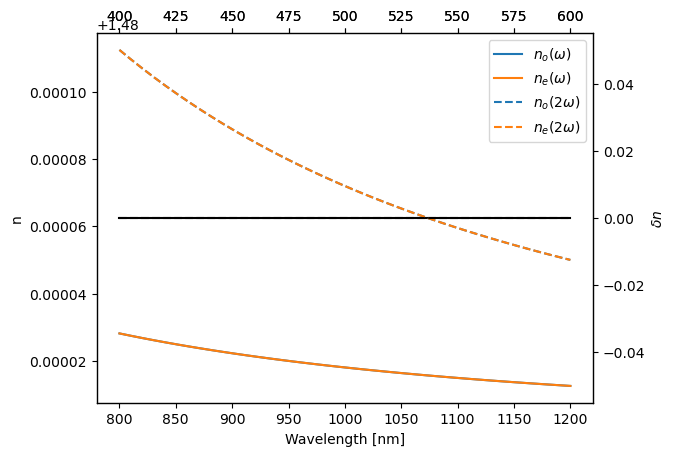

In [690]:
def ne(wavelength):
    return 1.6347 + 24151/(wavelength**2)
    return 1.8447 + 24151/(wavelength**2)

def no(wavelength):
    return 1.6347 + 24151/(wavelength**2)

def ne(wavelength):
    return 1.48 + 18/(wavelength**2)

def no(wavelength):
    return 1.48 + 18/(wavelength**2)


    
# we need to map to n1,n2,n3
n1 = no 
n2 = no 
n3 = ne 

# plot for visual inspection

fix, ax1 = plt.subplots(1)
axd1 = ax1.twinx()

plt.ylabel(r'$\delta n$')
ax2 = ax1.twiny()
axd2 = axd1.twiny()

l1 = ax1.plot(WAVELENGTHS, no(WAVELENGTHS), label = '$n_o(\omega)$')
l2 = ax1.plot(WAVELENGTHS, ne(WAVELENGTHS), label = '$n_e(\omega)$')

ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('n')

axd1.plot(WAVELENGTHS, ne(WAVELENGTHS) - no(WAVELENGTHS), 'k', label =r'$\delta n$')

l3 = ax2.plot(WAVELENGTHS/2, no(WAVELENGTHS/2), '--', label = '$n_o(2\omega)$')
l4 = ax2.plot(WAVELENGTHS/2, ne(WAVELENGTHS/2), '--',label = '$n_e(2\omega)$')

axd2.plot(WAVELENGTHS/2, ne(WAVELENGTHS/2) - no(WAVELENGTHS/2), 'k--')


ls = l1 + l2 + l3 + l4
lbls = [l.get_label() for l in ls]
plt.legend(ls, lbls)
plt.show()



### Director orientation

Here we define the three Euler angles $\psi,\theta,\phi$ as parametric functions that define the orientation of the eigenframe in the given voxel defined by a coordinate (x,y,z). The functions take a numpy array coordinates x,y,z and must return a new array of same shape and type. Then the program automatically build the required material Euler angles array used for calculation. 

We also define the three angles for a single-pixel run.

In case of uniaxial LC, you must set the $\theta$ and $\phi$ angles which correspond to the orientation of the director with respect to the laboratory coordinate frame. $\theta = 0$ is along the $z$ axis, $\theta = pi/2$ and $\phi=0$ is along the $x$ axis. 



Single-wave parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 0.000 - 1.571 rad
 Phi range:   0.000 - 1.571 rad

Multi-wavelength parameters
 Psi range:   0.000 - 0.000 rad
 Theta range: 1.571 - 1.571 rad
 Phi range:   0.000 - 0.000 rad
 I index : 0
 J index : 0


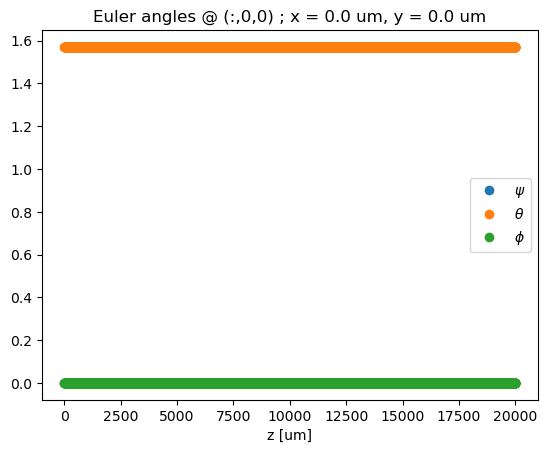

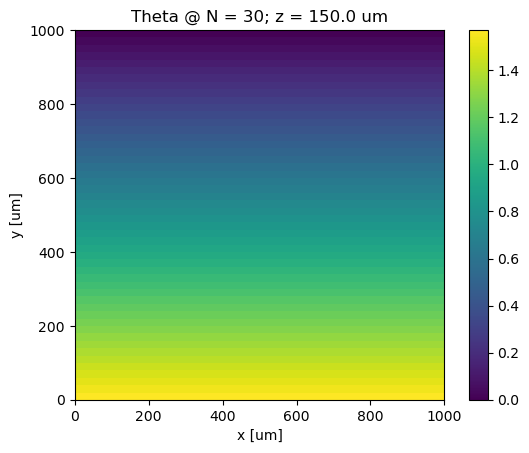

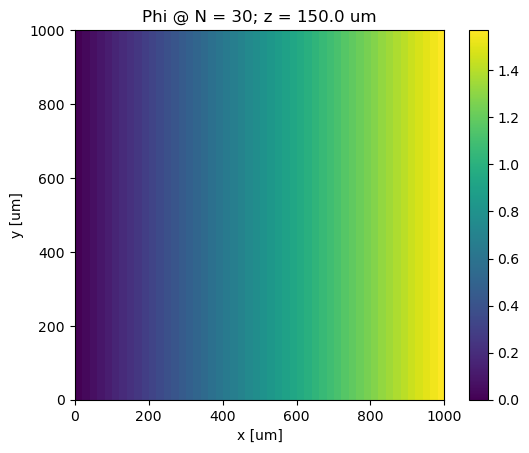

In [691]:
I = 0 # height index for single-pixel run
J = 0 # width index for single-pixel run

N = 30 # layer index for plotting

ROTATION = np.pi/2 # max rotation of the director along x
TILT = np.pi/2 # max tilt angle of the director along y

def psi(x,y,z):
    return 0 # For uniaxial set to zero or any value
    
def theta(x,y,z):
    return TILT - y/HEIGHT * TILT

def phi(x,y,z):
    return  x/WIDTH * ROTATION

# computed parameters. Do not change these!
#//////////////////////////////////////////

z = np.linspace(0,THICKNESS, SHAPE[0])
y = np.linspace(0,HEIGHT, SHAPE[1])
x = np.linspace(0,WIDTH, SHAPE[2])

#we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
zz,yy,xx = np.meshgrid(z,y,x, indexing = 'ij')

ANGLES = np.zeros(SHAPE+(3,))
ANGLES[...,1] = theta(xx,yy,zz)
ANGLES[...,2] = phi(xx,yy,zz)

def print_director_info():
    print('Single-wave parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,0].min(), ANGLES[...,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,1].min(), ANGLES[...,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,2].min(), ANGLES[...,2].max()))
    print()
    print('Multi-wavelength parameters')
    print(' Psi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,0].min(), ANGLES[...,I,J,0].max()))
    print(' Theta range: {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,1].min(), ANGLES[...,I,J,1].max()))
    print(' Phi range:   {:.3f} - {:.3f} rad'.format(ANGLES[...,I,J,2].min(), ANGLES[...,I,J,2].max()))
    print(f' I index : {I}' )
    print(f' J index : {J}' )
    
print_director_info()

# We plot angles with modulo 2 pi
pi2 = 2*np.pi

fig = plt.figure()
plt.plot(z, ANGLES[:,I,J,0]%pi2,'o',label = r'$\psi$')
plt.plot(z, ANGLES[:,I,J,1]%pi2,'o',label = r'$\theta$')
plt.plot(z, ANGLES[:,I,J,2]%pi2,'o',label = r'$\phi$')
plt.xlabel('z [um]')
plt.title(r'Euler angles @ (:,{},{}) ; x = {:.1f} um, y = {:.1f} um'.format(I,J,xx[N,I,J], yy[N,I,J]))
plt.legend()

fig = plt.figure()
im1 = plt.imshow(ANGLES[N,:,:,1]%pi2, origin = 'lower', extent = (0,HEIGHT, 0, WIDTH))
plt.title(r'Theta @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im1)
plt.xlabel('x [um]')
plt.ylabel('y [um]')

fig = plt.figure()
im2 = plt.imshow(ANGLES[N,:,:,2]%pi2, origin = 'lower', extent = (0,HEIGHT, 0, WIDTH))
plt.xlabel('x [um]')
plt.ylabel('y [um]')
plt.title(r'Phi @ N = {}; z = {:.1f} um'.format(N, z[N]))
fig.colorbar(im2)

# Calculation

## Data Initialization

In the initialization step we construct the epsilon tensor, field amplitudes and take care of broadcasting. Depending on the selected analysis mode, the output data is of different shape. See the analysis section for details.

In [692]:
set_analysis_mode('wavelength')

print(f'Initializing for "{MODE}" mode.')
    
if MODE == 'wavelength':
    
    jones = np.asarray(POLARIZATIONS)[:,None,:] 
    intensities = np.asarray(INTENSITIES)[None,:]
    
    f01 = fmat(BETA, PHI, EPSILON0[None,:], ANGLES0[None,:])
    f02 = fmat(BETA, PHI, EPSILON0[None,:], ANGLES0[None,:])
        
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),len(WAVELENGTHS), 4), dtype = CDTYPE)
    ampl[...,0] = jones[...,0] * (intensities*Z0)**0.5
    ampl[...,2] = jones[...,1] * (intensities*Z0)**0.5
    
    
    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],len(WAVELENGTHS),6))
    epsilon1[...,0] = n1(WAVELENGTHS)**2
    epsilon1[...,1] = n2(WAVELENGTHS)**2
    epsilon1[...,2] = n3(WAVELENGTHS)**2
    
    epsilon2 = np.zeros((SHAPE[0],len(WAVELENGTHS),6))
    epsilon2[...,0] = n1(WAVELENGTHS/2)**2
    epsilon2[...,1] = n2(WAVELENGTHS/2)**2
    epsilon2[...,2] = n3(WAVELENGTHS/2)**2
    
    angles = np.ones((SHAPE[0],1,3)) 
    angles[:,0] = ANGLES[:,I,J]
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01S,)* SHAPE[0])
    kds2 = np.array((K02S,)* SHAPE[0])

    E = np.empty((len(POLARIZATIONS),len(WAVELENGTHS),3), dtype = CDTYPE)


elif MODE == 'image':

    jones = np.asarray(POLARIZATIONS) 
    jones = jones[:,None,None,:] #add dummy axes for broadcasting
    
    f01 = fmat(BETA, PHI, EPSILON0[None,None,:], ANGLES0[None,None,:])
    f02 = fmat(BETA, PHI, EPSILON0[None,None,:], ANGLES0[None,None,:])
        
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),SHAPE[1],SHAPE[2], 4), dtype = CDTYPE)
    ampl[...,0] = jones[...,0] * (INTENSITY*Z0)**0.5
    ampl[...,2] = jones[...,1] * (INTENSITY*Z0)**0.5
    
    
    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],1,1,6))
    epsilon1[...,0] = n1(WAVELENGTH)**2
    epsilon1[...,1] = n2(WAVELENGTH)**2
    epsilon1[...,2] = n3(WAVELENGTH)**2
    
    epsilon2 = np.zeros((SHAPE[0],1,1,6))
    epsilon2[...,0] = n1(WAVELENGTH/2)**2
    epsilon2[...,1] = n2(WAVELENGTH/2)**2
    epsilon2[...,2] = n3(WAVELENGTH/2)**2
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01,)* SHAPE[0])[:,None,None]
    kds2 = np.array((K02,)* SHAPE[0])[:,None,None]

    angles = ANGLES

    intensities = INTENSITY

    
    E = np.empty((len(POLARIZATIONS),SHAPE[1],SHAPE[2],3), dtype = CDTYPE)


elif MODE == 'full':
    jones = np.asarray(POLARIZATIONS) #must be a normalized jones vector! 
    jones = jones[:,None,None,None,:] #add dummy axes for broadcasting
    
    f01 = fmat(BETA, PHI, EPSILON0[None,None,None,None,:], ANGLES0[None,None,None,None,:])
    f02 = fmat(BETA, PHI, EPSILON0[None,None,None,None,:], ANGLES0[None,None,None,None,:])
    
    intensities = np.asarray(INTENSITIES)[None,:,None,None]

    
    # Jones vector representation of the fundamental input beam in unitless amplitude notation.
    ampl = np.zeros((len(POLARIZATIONS),len(WAVELENGTHS), SHAPE[1],SHAPE[2], 4), dtype = CDTYPE)
    ampl[...,0] = jones[...,0] * (intensities*Z0)**0.5
    ampl[...,2] = jones[...,1] * (intensities*Z0)**0.5
    
    # epsilon tensors of fundamental and shg waves
    # we use numpy broadcasting rules here, so we add two empty axes  to match the angles array shape
    epsilon1 = np.zeros((SHAPE[0],1,1,1,6))
    epsilon1[...,0] = n1(WAVELENGTH)**2
    epsilon1[...,1] = n2(WAVELENGTH)**2
    epsilon1[...,2] = n3(WAVELENGTH)**2
    
    epsilon2 = np.zeros((SHAPE[0],1,1,6))
    epsilon2[...,0] = n1(WAVELENGTH/2)**2
    epsilon2[...,1] = n2(WAVELENGTH/2)**2
    epsilon2[...,2] = n3(WAVELENGTH/2)**2
    
    # normalized layer thickness of fundamental and shg waves
    kds1 = np.array((K01S,)* SHAPE[0])[:,None,:,None,None]
    kds2 = np.array((K02S,)* SHAPE[0])[:,None,:,None,None]

    angles = ANGLES

    E = np.empty((len(POLARIZATIONS),len(WAVELENGTHS),SHAPE[1],SHAPE[2],3), dtype = CDTYPE)


else:
    raise ValueError(f'Unknown mode {MODE}')

Initializing for "wavelength" mode.


## Fundamental wave

First, one has to compute the fundamental mode. We use the 4x4 matrix formalism to build the matrices, compute the total transfer matrix, the reflection matrices and the output field. The computed ouptut field serves as an input for the SHG calculation step. Pay attention to the 'Intensity relative loss standard deviation' calculated at the end, which should be a really small number. It is a measure of energy conservation violation. In nonabsorbing samples it should be close to zero. 

In [693]:
print('Building layer matrices of the fundamental wave')
# we propagate backward and only half step so that we can access mid-plane 
matrices1 = [layer_mat(-kds1[i]/2, epsilon1[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
print('Building layer matrices of the shg wave')
matrices2 = [layer_mat(-kds2[i]/2, epsilon2[i],angles[i], BETA,PHI) for i in range(SHAPE[0])]
print('Calculating stack matrices')
# we apply each matrix twice because these are half-layer matrices
stack_matrix1 = multi_dot((dotmm(m,m) for m in matrices1),reverse = False)
stack_matrix2 = multi_dot((dotmm(m,m)  for m in matrices2),reverse = False)
print('Calculating system matrices')
smat1 = system_mat(stack_matrix1, f01,f01)
smat2 = system_mat(stack_matrix2, f02,f02)
print('Calculating reflection matrices')
rmat1 = reflection_mat(smat1)
rmat2 = reflection_mat(smat2)

print('Transferring fundamental field')
# convert from amplitude coefficients to EH field vector
field1_in = avec2fvec(ampl,f01)
field2_in = np.zeros_like(field1_in)

# compute output field, also modifies the input field to add reflected part
field1_out = reflect(field1_in, rmat1,fmatin = f01, fmatout = f01)
field2_out = reflect(field2_in, rmat2,fmatin = f02, fmatout = f02)

# convert to amplitude coefficients
ampl1_in = fvec2avec(field1_in,f01)
ampl1_out = fvec2avec(field1_out,f01)

# reflected field intensity
intensity1r = np.abs(ampl1_in[...,1])**2 + np.abs(ampl1_in[...,3])**2
intensity1r/=Z0

# transmitted field intensity
intensity1t = np.abs(ampl1_out[...,0])**2 + np.abs(ampl1_out[...,2])**2
intensity1t/=Z0

# this should be zero except for a small numerical error.
loss = (intensity1t+intensity1r - intensities)/intensities

#plt.imshow(loss[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity relative loss')
#plt.colorbar()
print('Done!')
print()
print('Intensity relative loss standard deviation', loss.std())

Building layer matrices of the fundamental wave
Building layer matrices of the shg wave
Calculating stack matrices
Calculating system matrices
Calculating reflection matrices
Transferring fundamental field
Done!

Intensity relative loss standard deviation 1.1239378872425192e-12


## SHG wave 

Once the fundamental field was calculated, you can run the SHG calculation step. It takes the ouptut field and propagates it back through the sample, creating SHG field. If depletion of the fundamental beam is not weak one should perform multiple SHG compuation steps. Each time we run this, we start with the fields computed from the previous run. 

In [696]:
NRUNS =10

for run in range(NRUNS):
    print(f'Computing SHG field (run {run+1}/{NRUNS})...')
    
    field1 = field1_out.copy()
    field2 = field2_out.copy()
    
    gain1 = np.zeros_like(field1)
    gain2 = np.zeros_like(field2)
    

    for p,i in enumerate(reversed(range(SHAPE[0]))):
        print_progress(p,SHAPE[0])

        lmat2_ref = matrices2[i]
        lmat1_ref = matrices1[i]

        # propagate both fields to mid plane
        field1h = dotmv(lmat1_ref,field1)
        field2h = dotmv(lmat2_ref,field2)

        #field1h+=field2h
        
        # obtain E vector
        E[...,0] = field1h[...,0]
        E[...,1] = field1h[...,1]
        EH = EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        E[...,2] = EH[...,0]

        #obtain rotation matrix 
        r = rotation_matrix(angles[i])
        rT = np.swapaxes(r,-1,-2)
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
        
        # compute nl susceptibility tensor
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E))

        # add perturbation to epsilon tensor of the SH wavlength
        epsilon_nl = epsilon2[i] + chi2_eff 
        #epsilon_nl = epsilon1[i] + chi2_eff 
        # compute perturbed layer matrix
        lmat2 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        #lmat2 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])

        # propagate reference field and perturbed fields
        field_ref2 = dotmv(lmat2_ref, field1h)
        #field_ref2 = dotmv(lmat1_ref, field1h)
        field_nlo2 = dotmv(lmat2, field1h)

        # difference is the excited SHG field. Times 2 
        dif2 = (field_nlo2 - field_ref2)
    
        E[...,0] = field1h[...,0]#.conj()
        E[...,1] = field1h[...,1]#.conj()
        EH = EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        E[...,2] = EH[...,0]
        
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
    
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E.conj()))
    
        epsilon_nl = epsilon1[i] +  chi2_eff 
    
        lmat1 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])
        #lmat1 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        #lmat1s = layer_mat(kds1[i]/2, epsilon1[i]  ,angles[i])         
        field_ref1 = dotmv(lmat1_ref, field2h)
        #field_ref1 = dotmv(lmat2_ref, field2h)
        field_nlo1 = dotmv(lmat1, field2h)
        
        dif1 = (field_nlo1 - field_ref1)*2

        #dif2 = dotmv(lmat2_ref, dif2)
        #dif1 = dotmv(lmat1_ref, dif1)

        #dif1 = dif1.conj()
        lmat2_ref = dotmm(lmat2_ref,lmat2_ref)
        lmat1_ref = dotmm(lmat1_ref,lmat1_ref)
        
        gain1 = dotmv(lmat1_ref, gain1)
        gain2 = dotmv(lmat2_ref, gain2)
        
        field1 = dotmv(lmat1_ref, field1)
        field2 = dotmv(lmat2_ref, field2)
    
        gain1 += dif1
        field1 += dif1
        
        gain2 += dif2
        field2 += dif2
    print_progress(SHAPE[0],SHAPE[0])
    

    field2_out = reflect(field2_in, rmat2, fmatin = f02, fmatout = f02, gvec = gain2)
    field1_out = reflect(field1_in, rmat1, fmatin = f01, fmatout = f01, gvec = gain1)   
    
    ampl1_in = fvec2avec(field1_in,f01)
    ampl1_out = fvec2avec(field1_out,f01)
    
    intensity1r = np.abs(ampl1_in[...,1])**2 + np.abs(ampl1_in[...,3])**2
    intensity1r/=Z0
    intensity1t = np.abs(ampl1_out[...,0])**2 + np.abs(ampl1_out[...,2])**2
    intensity1t/=Z0
    
    ampl2_in = fvec2avec(field2_in,f02)
    ampl2_out = fvec2avec(field2_out,f02)
    
    intensity2r = np.abs(ampl2_in[...,1])**2 + np.abs(ampl2_in[...,3])**2
    intensity2r/=Z0
    intensity2t = np.abs(ampl2_out[...,0])**2 + np.abs(ampl2_out[...,2])**2
    intensity2t/=Z0
    
    total_intensity = intensity1t+intensity1r+intensity2t+intensity2r

    loss = (total_intensity - intensities)/intensities
    print('Intensity relative loss std', loss.std())

#plt.imshow(total_intensity[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity It1+It2+Ir1+Ir2')
#plt.colorbar()
print('Done!')

Computing SHG field (run 1/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015788665709097453
Computing SHG field (run 2/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015786249014262648
Computing SHG field (run 3/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015785145534124486
Computing SHG field (run 4/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015785428809652412
Computing SHG field (run 5/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015785551557511007
Computing SHG field (run 6/10)...
 |==================================================| 100.0% 
Intensity relative loss std 0.00015785517465436873
Computing SHG field (run 7/10)...
 |==================================================| 100.0% 
Intensity relative los

In [655]:
NRUNS =3

for run in range(NRUNS):
    print(f'Computing SHG field (run {run+1}/{NRUNS})...')
    
    field1 = field1_out.copy()
    field2 = field2_out.copy()
    
    gain1 = np.zeros_like(field1)
    gain2 = np.zeros_like(field2)
    

    for p,i in enumerate(reversed(range(SHAPE[0]))):
        print_progress(p,SHAPE[0])

        lmat2_ref = matrices2[i]
        lmat1_ref = matrices1[i]

        # propagate both fields to mid plane
        field1h = dotmv(lmat1_ref,field1)
        field2h = dotmv(lmat2_ref,field2)

        #field1h+=field2h
        
        # obtain E vector
        E[...,0] = field1h[...,0]
        E[...,1] = field1h[...,1]
        EH = EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        E[...,2] = EH[...,0]

        #obtain rotation matrix 
        r = rotation_matrix(angles[i])
        rT = np.swapaxes(r,-1,-2)
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
        
        # compute nl susceptibility tensor
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E))

        # add perturbation to epsilon tensor of the SH wavlength
        epsilon_nl = epsilon2[i] + chi2_eff 
        #epsilon_nl = epsilon1[i] + chi2_eff 
        # compute perturbed layer matrix
        lmat2 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])
        lmat2_ref2 = layer_mat(-kds1[i]/2, epsilon2[i]  ,angles[i])
        #lmat2 = layer_mat(-kds1[i]/2, epsilon_nl  ,angles[i])

        # propagate reference field and perturbed fields
        field_ref2 = dotmv(lmat2_ref2, field1h)
        #field_ref2 = dotmv(lmat1_ref, field1h)
        field_nlo2 = dotmv(lmat2, field1h)

        # difference is the excited SHG field. Times 2 
        dif2 = (field_nlo2 - field_ref2)*2
    
        E[...,0] = field1h[...,0]#.conj()
        E[...,1] = field1h[...,1]#.conj()
        EH = EHz(field1h,BETA,PHI, epsilon1[i], angles[i])   
        E[...,2] = EH[...,0]
        
        # rotate field to eigenframe        
        E = rotate_vector(rT, E)
    
        chi2_eff = matrix2tensor(dotchi2v(CHI2,E.conj()))
    
        epsilon_nl = epsilon2[i] +  chi2_eff 
    
        lmat1 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        lmat1_ref2 = layer_mat(-kds2[i]/2, epsilon2[i]  ,angles[i])
        #lmat1 = layer_mat(-kds2[i]/2, epsilon_nl  ,angles[i])
        #lmat1s = layer_mat(kds1[i]/2, epsilon1[i]  ,angles[i])         
        field_ref1 = dotmv(lmat1_ref2, field2h)
        #field_ref1 = dotmv(lmat2_ref, field2h)
        field_nlo1 = dotmv(lmat1, field2h)
        
        dif1 = (field_nlo1 - field_ref1)

        #dif2 = dotmv(lmat2_ref, dif2)
        #dif1 = dotmv(lmat1_ref, dif1)

        #dif1 = dif1.conj()
        lmat2_ref = dotmm(lmat2_ref,lmat2_ref)
        lmat1_ref = dotmm(lmat1_ref,lmat1_ref)
        
        gain1 = dotmv(lmat1_ref, gain1)
        gain2 = dotmv(lmat2_ref, gain2)
        
        field1 = dotmv(lmat1_ref, field1)
        field2 = dotmv(lmat2_ref, field2)
    
        gain1 += dif1
        field1 += dif1
        
        gain2 += dif2
        field2 += dif2
    print_progress(SHAPE[0],SHAPE[0])
    

    field2_out = reflect(field2_in, rmat2, fmatin = f02, fmatout = f02, gvec = gain2)
    field1_out = reflect(field1_in, rmat1, fmatin = f01, fmatout = f01, gvec = gain1)   
    
    ampl1_in = fvec2avec(field1_in,f01)
    ampl1_out = fvec2avec(field1_out,f01)
    
    intensity1r = np.abs(ampl1_in[...,1])**2 + np.abs(ampl1_in[...,3])**2
    intensity1r/=Z0
    intensity1t = np.abs(ampl1_out[...,0])**2 + np.abs(ampl1_out[...,2])**2
    intensity1t/=Z0
    
    ampl2_in = fvec2avec(field2_in,f02)
    ampl2_out = fvec2avec(field2_out,f02)
    
    intensity2r = np.abs(ampl2_in[...,1])**2 + np.abs(ampl2_in[...,3])**2
    intensity2r/=Z0
    intensity2t = np.abs(ampl2_out[...,0])**2 + np.abs(ampl2_out[...,2])**2
    intensity2t/=Z0
    
    total_intensity = intensity1t+intensity1r+intensity2t+intensity2r

    loss = (total_intensity - intensities)/intensities
    print('Intensity relative loss std', loss.std())

#plt.imshow(total_intensity[0,0], origin = 'lower',cmap = 'gray')#, vmin = 0, vmax = INTENSITY)
#plt.title('Total intensity It1+It2+Ir1+Ir2')
#plt.colorbar()
print('Done!')

Computing SHG field (run 1/3)...
 |==================================================| 100.0% 
Intensity relative loss std 0.0937574990400058
Computing SHG field (run 2/3)...
 |==================================================| 100.0% 
Intensity relative loss std 0.04274180813458293
Computing SHG field (run 3/3)...
 |==================================================| 100.0% 
Intensity relative loss std 0.010629572927779309
Done!


Image analysis

### Wave intensity

In [8]:
if MODE != 'image':
    1/0
    
PINDEX = 0

polname = polstr(POLARIZATIONS[PINDEX])
extent = []

plt.imshow(intensity1r[PINDEX], label = 'R', origin = 'lower',cmap = 'gray')
plt.title(f'$R(\omega_1)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity1t[PINDEX], label = 'T', origin = 'lower',cmap = 'gray')
plt.title(f'$T(\omega_1)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity2r[PINDEX], label = 'R', origin = 'lower',cmap = 'gray')
plt.title(f'$R(\omega_2)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX], label = 'T', origin = 'lower',cmap = 'gray')
plt.title(f'$T(\omega_2)$ @ P = {polname}')
plt.colorbar()
plt.figure()
plt.imshow(total_intensity[PINDEX], origin = 'lower',cmap = 'gray')
plt.title('Total intensity')
plt.colorbar()
    

ZeroDivisionError: division by zero

## Wavelength analysis

[19.76925717 19.27190965 18.7930972  18.33191009 17.88749375 17.45904477
 17.04580727 16.64706959 16.26216121 15.89044991 15.53133921 15.18426593
 14.84869804 14.52413253 14.21009364 13.90613102 13.61181814 13.32675083
 13.05054584 12.78283958 12.52328692 12.27156007 12.02734756 11.79035324
 11.56029542 11.33690603 11.11992981 10.9091236  10.70425567 10.50510504
 10.31146094 10.12312222  9.93989683  9.76160131  9.58806039  9.41910651
  9.2545794   9.09432577  8.93819888  8.78605825]


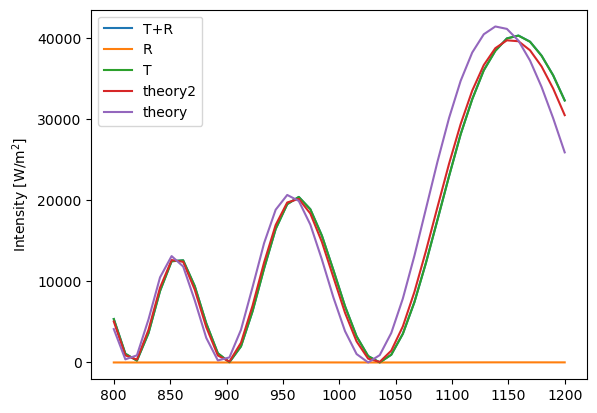

In [697]:
if MODE != 'wavelength':
    1/0
    
D33 = 5.6e-12*100
PINDEX = 0
def theory(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2)+0.000000001
    lamb = wavelength * 1e-9
    
    deltak = 4 * np.pi * (ne2w- new)/lamb 
    c = 3e8
    eps0 = 8.85e-12

    return intensity**2 *32* np.pi**2 * D33**2 / lamb**2 / c/eps0/new**2/ne2w *np.sin(deltak * THICKNESS/2*1e-6)**2/(deltak**2)

def theory2(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2) 
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w- new)* L
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new

    E2w = Ew2**0.5*np.tanh(k*L*D33* Ew2**0.5/ne2w*np.sin(deltakl)/(deltakl))

    return 0.5*eps0*c*ne2w * E2w**2
    
def theory3(wavelength, intensity):
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) + 0.000000001
    no2w = no(wavelength/2) + 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w - new)* L*2
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new
    

    E2w = Ew2**0.5* np.tanh(k*L*D33* Ew2**0.5/ne2w*(np.exp(1j*deltakl)-1)/deltakl)

    E2w = Ew2**0.5* np.tanh(k*L*D33* Ew2**0.5/ne2w*(np.exp(1j*deltakl)-1)/deltakl)
    return 0.5*eps0*c*ne2w * np.abs(E2w)**2
    
import scipy.special        
def theory4(wavelength, intensity):
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) #+ 0.000000001
    no2w = no(wavelength/2) #+ 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltak = k* (ne2w - new)*2
    c = 3e8
    eps0 = 8.85e-12

    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/4/D33
    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/D33/2/np.pi

    print(fact*deltak)

    deltar = fact *deltak

    

    c = deltar/2*(1+(deltar**2)/16)**0.5

    a = (1+(deltar**2)/8-c)**0.5
    #a=  2/deltar
    b = (1+(deltar**2)/8+c)**0.5



    u = b/fact*L
    m = a/b
    sn,_,_,_ = scipy.special.ellipj(u, a/b)

    return intensity * a**2* sn**2





plt.plot((WAVELENGTHS), intensity2t[PINDEX]+intensity2r[PINDEX], label = 'T+R')
plt.plot((WAVELENGTHS), intensity2r[PINDEX], label = 'R')
plt.plot((WAVELENGTHS), intensity2t[PINDEX], label = 'T')
plt.plot(WAVELENGTHS, theory4(WAVELENGTHS,INTENSITY).real, label = 'theory2')
plt.plot(WAVELENGTHS, theory (WAVELENGTHS,INTENSITY), label = 'theory')
plt.plot()

plt.ylabel('Intensity [W/m$^2$]')
plt.legend()

[19.76925717 19.27190965 18.7930972  18.33191009 17.88749375 17.45904477
 17.04580727 16.64706959 16.26216121 15.89044991 15.53133921 15.18426593
 14.84869804 14.52413253 14.21009364 13.90613102 13.61181814 13.32675083
 13.05054584 12.78283958 12.52328692 12.27156007 12.02734756 11.79035324
 11.56029542 11.33690603 11.11992981 10.9091236  10.70425567 10.50510504
 10.31146094 10.12312222  9.93989683  9.76160131  9.58806039  9.41910651
  9.2545794   9.09432577  8.93819888  8.78605825]


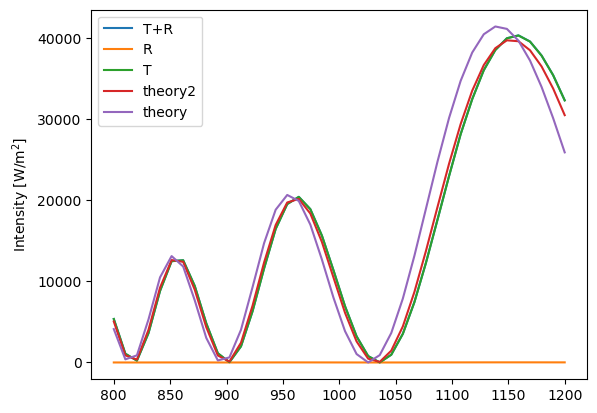

In [688]:
if MODE != 'wavelength':
    1/0
    
D33 = 5.6e-12*100
PINDEX = 0
def theory(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2)+0.000000001
    lamb = wavelength * 1e-9
    
    deltak = 4 * np.pi * (ne2w- new)/lamb 
    c = 3e8
    eps0 = 8.85e-12

    return intensity**2 *32* np.pi**2 * D33**2 / lamb**2 / c/eps0/new**2/ne2w *np.sin(deltak * THICKNESS/2*1e-6)**2/(deltak**2)

def theory2(wavelength, intensity):
    new = ne(wavelength)
    ne2w = ne(wavelength/2) 
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w- new)* L
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new

    E2w = Ew2**0.5*np.tanh(k*L*D33* Ew2**0.5/ne2w*np.sin(deltakl)/(deltakl))

    return 0.5*eps0*c*ne2w * E2w**2
    
def theory3(wavelength, intensity):
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) + 0.000000001
    no2w = no(wavelength/2) + 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltakl = k* (ne2w - new)* L*2
    c = 3e8
    eps0 = 8.85e-12

    Ew2 = 2*intensity/c/eps0/new
    

    E2w = Ew2**0.5* np.tanh(k*L*D33* Ew2**0.5/ne2w*(np.exp(1j*deltakl)-1)/deltakl)

    E2w = Ew2**0.5* np.tanh(k*L*D33* Ew2**0.5/ne2w*(np.exp(1j*deltakl)-1)/deltakl)
    return 0.5*eps0*c*ne2w * np.abs(E2w)**2
    
import scipy.special        
def theory4(wavelength, intensity):
    new = ne(wavelength)
    now = no(wavelength)
    ne2w = ne(wavelength/2) #+ 0.000000001
    no2w = no(wavelength/2) #+ 0.000000001
    
    lamb = wavelength * 1e-9
    L = THICKNESS *1e-6
    k = 2*np.pi/ lamb
    
    deltak = k* (ne2w - new)*2
    c = 3e8
    eps0 = 8.85e-12

    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/4/D33
    fact = (eps0*c*ne2w/2/intensity)**0.5 *new*lamb/D33/2/np.pi

    print(fact*deltak)

    deltar = fact *deltak

    

    c = deltar/2*(1+(deltar**2)/16)**0.5

    a = (1+(deltar**2)/8-c)**0.5
    #a=  2/deltar
    b = (1+(deltar**2)/8+c)**0.5



    u = b/fact*L
    m = a/b
    sn,_,_,_ = scipy.special.ellipj(u, a/b)

    return intensity * a**2* sn**2





plt.plot((WAVELENGTHS), intensity2t[PINDEX]+intensity2r[PINDEX], label = 'T+R')
plt.plot((WAVELENGTHS), intensity2r[PINDEX], label = 'R')
plt.plot((WAVELENGTHS), intensity2t[PINDEX], label = 'T')
plt.plot(WAVELENGTHS, theory4(WAVELENGTHS,INTENSITY).real, label = 'theory2')
plt.plot(WAVELENGTHS, theory (WAVELENGTHS,INTENSITY), label = 'theory')
plt.plot()

plt.ylabel('Intensity [W/m$^2$]')
plt.legend()

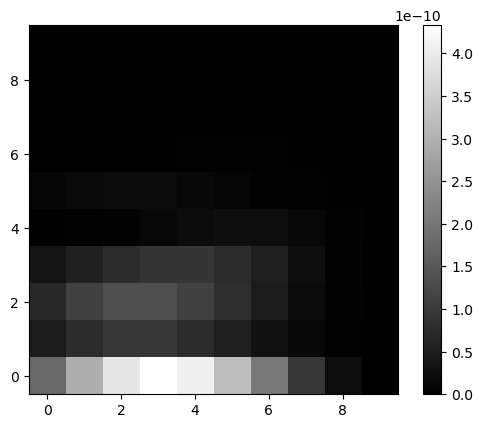

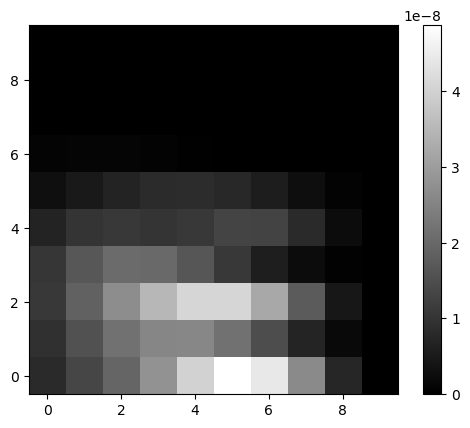

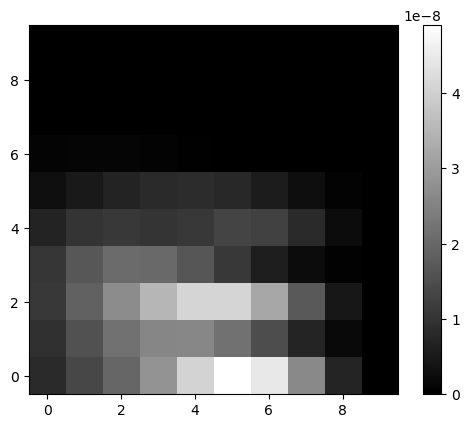

In [239]:
if MODE != 'full':
    1/0
    
PINDEX = 0
plt.imshow(intensity2r[PINDEX,0], label = 'R', origin = 'lower',cmap = 'gray')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX,0], label = 'T', origin = 'lower',cmap = 'gray')
plt.colorbar()
plt.figure()
plt.imshow(intensity2t[PINDEX,0]+intensity2r[PINDEX,0], origin = 'lower',cmap = 'gray')
plt.colorbar()

In [16]:
theory(500,1e6)

100.78923482251327

In [409]:
scipy.special.ellipj(1, 0.9)[0]

0.7700857249078807

In [408]:
np.tanh(1)

0.7615941559557649